In [1]:
from pyrep import PyRep
from pyrep.robots.arms.panda import Panda
from pyrep.robots.end_effectors.panda_gripper import PandaGripper
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

In [2]:
pr = PyRep()
pr.launch('scene_panda_insert_target.ttt', headless=False)
pr.start()
agent = Panda()

In [3]:
# Generate demo
target=[0.47, 0.54, 0.9]

pose_list = []
for j in range(100):
    pos, quat = agent.get_tip().get_position(), agent.get_tip().get_quaternion()

    delta = -0.05*(pos - target)
    pos = pos + delta
    new_joint_angles = agent.solve_ik(pos, quaternion=quat)
    agent.set_joint_target_positions(new_joint_angles)
    pr.step()
    
    if np.sum((pos-target)**2) < 0.001:
        break
    
    pose_list.append(delta)
    

In [4]:
def randomise_start(sig_pos=1e-2):
    starting_joint_positions = agent.get_joint_positions()
    pos, quat = agent.get_tip().get_position(), agent.get_tip().get_quaternion()
    pos = pos + sig_pos*np.random.randn(3)
    new_joint_angles = agent.solve_ik(pos, quaternion=quat)
    agent.set_joint_target_positions(new_joint_angles)
    for j in range(10):
        pr.step()
    
def insert(d_pose_list):
    # Return to start
    f = []
    for p in d_pose_list:
        pos, quat = agent.get_tip().get_position(), agent.get_tip().get_quaternion()
        new_joint_angles = agent.solve_ik(p[0:3]+pos, quaternion=quat)
        agent.set_joint_target_positions(new_joint_angles)
        pr.step()
        plt.cla()
        f.append(agent.get_object('Panda_gripper_attach_point').read()[0])
        plt.plot(np.vstack(f))
        plt.ylabel('Force')
        plt.grid()
        display.clear_output(wait=True)
        display.display(plt.gcf())
    
def extract(d_pose_list):
    # Return to start
    f = []
    for p in reversed(d_pose_list):
        pos, quat = agent.get_tip().get_position(), agent.get_tip().get_quaternion()
        new_joint_angles = agent.solve_ik(pos-p[0:3], quaternion=quat)
        agent.set_joint_target_positions(new_joint_angles)
        pr.step()
        f.append(agent.get_object('Panda_gripper_attach_point').read()[0])
        plt.cla()
        plt.plot(np.vstack(f))
        plt.ylabel('Force')
        plt.grid()
        display.clear_output(wait=True)
        display.display(plt.gcf())
#         if agent.get_object('Cuboid').check_collision():
#             print ('Collision')

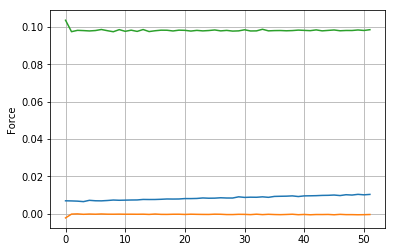

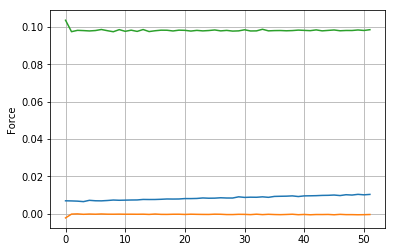

In [5]:
force_torque = agent.get_object('Panda_gripper_attach_point').read()
extract(pose_list)

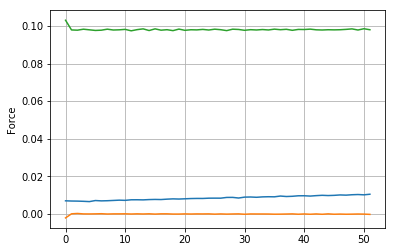

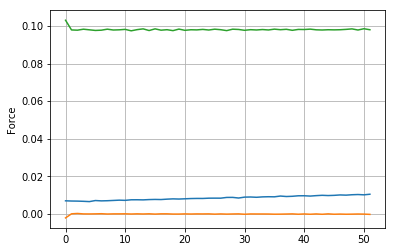

In [7]:
pr.start()

randomise_start(sig_pos=5e-2)
insert(pose_list)
extract(pose_list)

pr.stop()